# How to Run DESC and DISC on the Iris Dataset 

First, we load IRIS dataset and convert it into a sparse binary matrix format.

In [82]:
import numpy as np
from sklearn.datasets import load_iris

def fetch_iris():
    iris = load_iris()
    data = iris.data.round(0)
    labels = list(iris.target.astype(int))

    data[:,0] -= min(data[:,0])
    for c in [1, 2, 3]:
        data[:,c] -= min(data[:,c]) - max(data[:,c - 1]) - 1
        
    data = list(data.astype(int))
    
    return data, labels

In [83]:
x, y = fetch_iris()
dim = max([max(e) for e in x])

# Summarizing a single dataset

We start with discovering a solution to the summary problem for this dataset. That is the problem of discovering a set of patterns that together are informative, non-redundant and concise to be interpretable.

Informative Pattern Set Mining is implemented in disc and can be used in the following way

In [84]:
from disc import *

result = desc(x)

This function returns a python dictionary that among others contains the discovered pattern set. 

As this result also contains singletons, we are going to report patterns of at least length 2 in the following

In [85]:
S = result["pattern_set"] #includes singletons
patterns = [x for x in S if len(x) > 1]

The patterns in that set are sorted by the step in which we have inserted that pattern.

To quantify the results in terms of BIC in a meaningful way, we can compute the BIC ratio (lower is better) with respect to the initial model used to describe the data, that is $S = I$. The BIC ratio our discovery $S$ has achieved can be computed by means of

In [86]:
bic_ratio_desc = result['objective'][0] / result['initial_objective'][0]

# Summarizing a multiple datasets

Similar to the above, we are interested in discovering the pattern sets that summarize the data well. 

However, DESC can not only discover a single summary for multiple datasets at once, but it can also explain which patterns are _characteristic_ for a dataset and which patterns are _shared_ across arbitrary datasets.

In case of this example we are given classes, for which we use desc to discover characteristic and shared patterns.

In [87]:
result = desc(x, y)

Similar to the first example, DESC has discovered the pattern set 

In [88]:
S = result["pattern_set"] 
patterns = [x for x in S if len(x) > 1]

But this time, we also found the assignment of each pattern to a component, if that pattern is characteristic for a dataset.

DESC encodes this in terms of the assignment matrix $A$, where $A_{j,i}$ is $1$ if pattern $x_i$ is characteristic for class $j$. A shared pattern is simply a pattern that is characteristic for multiple datasets. This matrix can be found in the result in terms of

In [89]:
A = result["assignment_list"] 

Next, we show the set of patterns that are characteristic for e.g. class 1 and class 2. We do this by extrating the patterns from S using assignment matrix $A_{ij}$. However, the assignment matrix also assignes singletons and since these are not very interesting in this example, we only consider larger patterns by slicing $A$ in the following way. 

In [90]:
I_1 = A[0][dim:]
I_2 = A[1][dim:]

S_1 = [S[i] for i in I_1]
S_2 = [S[i] for i in I_2]

Similarly, the set of shared patterns between class 1 and class 2 can be extracted 

In [91]:
I_12 = set(I_1).intersection(I_2)
S_12 = [S[i] for i in I_12]

Finally, the set that is unique patterns for class 1 or class 2 is

In [92]:
U_1 = [S[i] for i in set(I_1) - I_12]
U_2 = [S[i] for i in set(I_2) - I_12]

For given class labels, DESC_y achieve a BIC ratio of

In [93]:
bic_ratio_desc_y = result['objective'][0] / result['initial_objective'][0]

# Discovering the Composition

Now what happens, if we are not provided with multiple classes?

In this scenario, we are interested in the discovery of the pattern composition of the dataset. That is, we want to partition the dataset into clusters, where each cluster is significantly differently distributed from all the other clusters while we describe these partitions in terms of characteristic and shared patterns.

The goal is not to reproduce latent class labels but to provide insights into data by showing regions that have a peculiar distribution in comparison to the rest.

This method is called DISC.


In [94]:
result = disc(x, int(len(x) * 0.01))

For the sake of this example, we set the minimal support of a candidate pattern to be under consideration to a whopping 1 %.

The partitions that exhibit a significantly different distribution from the rest are exposed via data labels

In [95]:
y = result['labels']

This data composition gives us a BIC ratio of 

In [96]:
bic_ratio_disc = result['objective'][0] / result['initial_objective'][0]

and is described in terms of shared and characteristic patterns similar to the above

In [97]:
A = result['assignment_list']
S = result["pattern_set"]

Now, lets answer what is characteristic for class 1. That is simply

In [98]:
S_1 = [S[i] for i in A[0][dim:]]

Next, we show the patterns that are shared between classes 1,2 and 4. That can be done by taking the intersection of these assignments

In [99]:
I_124 = set(A[0][dim:]).intersection(A[1][dim:]).intersection(A[3][dim:])
S_124 = [S[i] for i in I_124]

Which leads us to the question of what patterns are unique for class 1, which are exactly the following

In [100]:
rest=set(A[1][dim:]).union(A[2][dim:]).union(A[3][dim:])
U_1 = [S[i] for i in set(A[0][dim:]) - rest]

To summarize the results above, we can visualize the achievements of DESC, DESC_y and DISC in terms of their respective BIC scores

<BarContainer object of 3 artists>

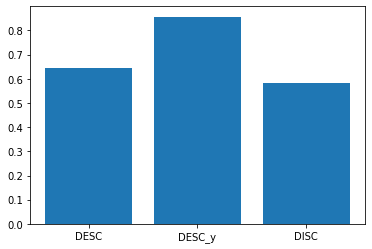

In [101]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.bar(["DESC", "DESC_y", "DISC"], [bic_ratio_desc, bic_ratio_desc_y, bic_ratio_disc])

We see that the difference BIC ratios of DESC and DESC_y is considerable. This observation simply means that the class labels that we have provided to DESC_y contains a significant amount of information and data within the classes is homogeneous that we do not need to explain these classes in terms of a sophisticated pattern set like DESC has to do it. 

DISC discovered a different partitioning that overall achieves the best ratio with more diverging distributions than DESC_y. 
Here, the smaller difference of DESC and DISC is due to the significantly larger regularizer/model cost used by DISC in comparison to DESC.

Thank you for your time!